In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn
import matplotlib
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

In [2]:
STOCK = "SISE.IS"
PERIOD_HISTORY = "1y"
PERIOD_ESTIMATION = 30
PERIOD_CV = "5 days"
PERIOD_HORIZON = "60 days"

In [3]:
tick = yf.Ticker(STOCK)

In [4]:
hist = tick.history(period=PERIOD_HISTORY, actions=False)
hist["Date"] = hist.index
hist = hist.set_index([[i for i in range(len(hist))]])

In [5]:
hist.head(5)

,Open,High,Low,Close,Volume,Date
0,4.859741,4.995814,4.820864,4.947217,54799214,2020-01-08
1,5.034692,5.131887,5.034692,5.122168,66003546,2020-01-09
2,5.151326,5.190204,5.112448,5.161046,56652865,2020-01-10
3,5.209643,5.287399,5.199923,5.248521,75450934,2020-01-13
4,5.248521,5.306838,5.209643,5.267960,75875277,2020-01-14


In [6]:
hist.describe()["Close"]

count    251.000000
mean       5.753402
std        1.026951
min        3.605928
25%        4.947217
50%        5.830000
75%        6.715000
max        7.770000
Name: Close, dtype: float64

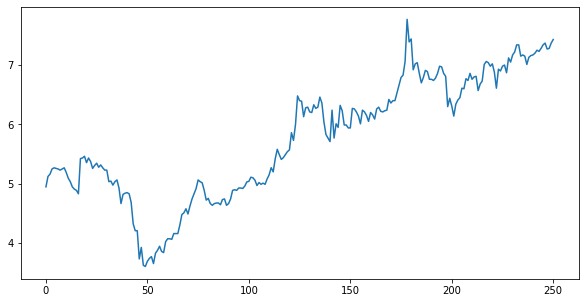

In [7]:
hist["Close"].plot(figsize=(10, 5))

plt.savefig("out/stock_prices.png")

In [8]:
data = hist[["Date", "Close"]]
data = data.rename(columns={"Date": "ds", "Close": "y"})

data.head(5)

,ds,y
0,2020-01-08,4.947217
1,2020-01-09,5.122168
2,2020-01-10,5.161046
3,2020-01-13,5.248521
4,2020-01-14,5.267960


In [9]:
df_train = data[0:int(len(data)-(PERIOD_ESTIMATION/2))]

In [10]:
model = Prophet()
model.add_country_holidays(country_name="TR")
model.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
future = model.make_future_dataframe(periods=PERIOD_ESTIMATION)

future["day"] = future["ds"].dt.weekday
future = future[future["day"] <= 4]

In [12]:
preds = model.predict(future)
preds[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(5)

,ds,yhat,yhat_lower,yhat_upper
252,2021-01-11,7.217230,6.830758,7.618904
253,2021-01-12,7.250333,6.874840,7.657722
254,2021-01-13,7.236841,6.874835,7.648713
255,2021-01-14,7.222409,6.843136,7.606659
256,2021-01-15,7.250836,6.850248,7.665075


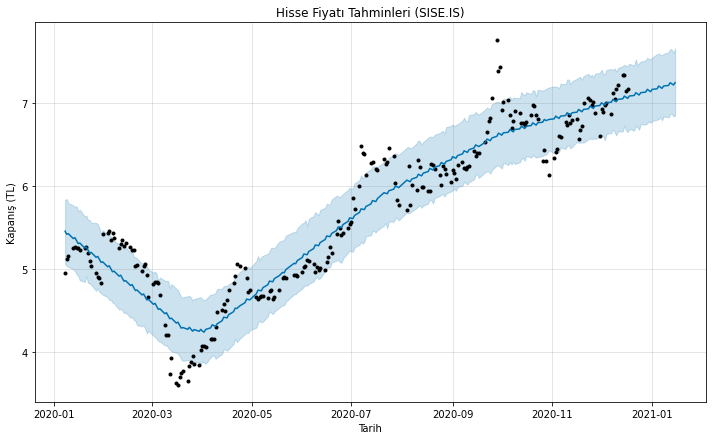

In [13]:
model.plot(preds)

plt.title("Hisse Fiyatı Tahminleri ({})".format(STOCK))
plt.xlabel("Tarih")
plt.ylabel("Kapanış (TL)")
plt.show()

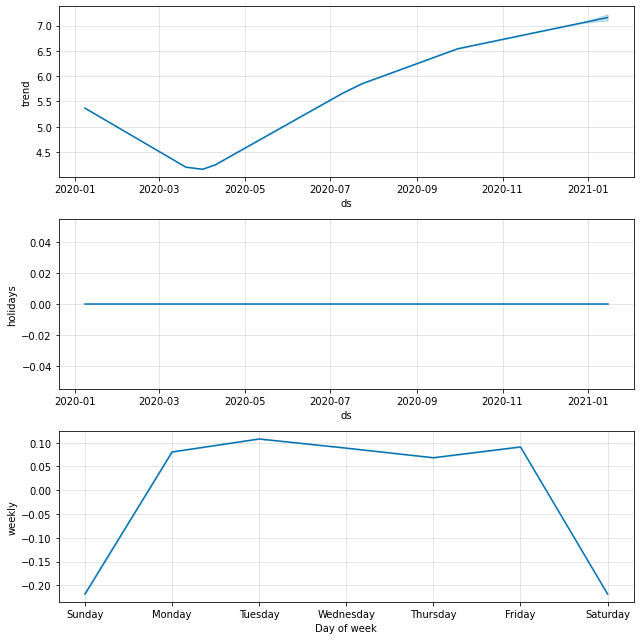

In [14]:
model.plot_components(preds)
plt.show()

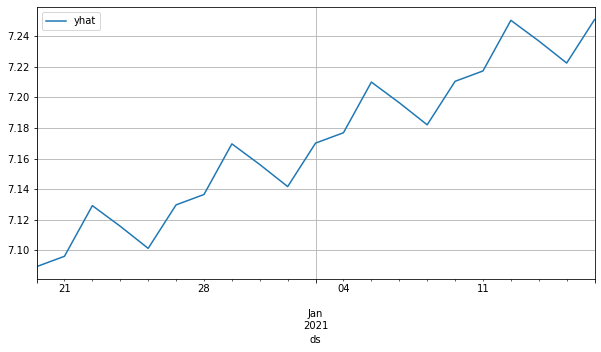

In [15]:
preds[len(df_train):int(len(df_train)+(PERIOD_ESTIMATION))].plot(x="ds", y="yhat", grid=True, figsize=(10, 5))

plt.savefig("out/stock_estimates.png")

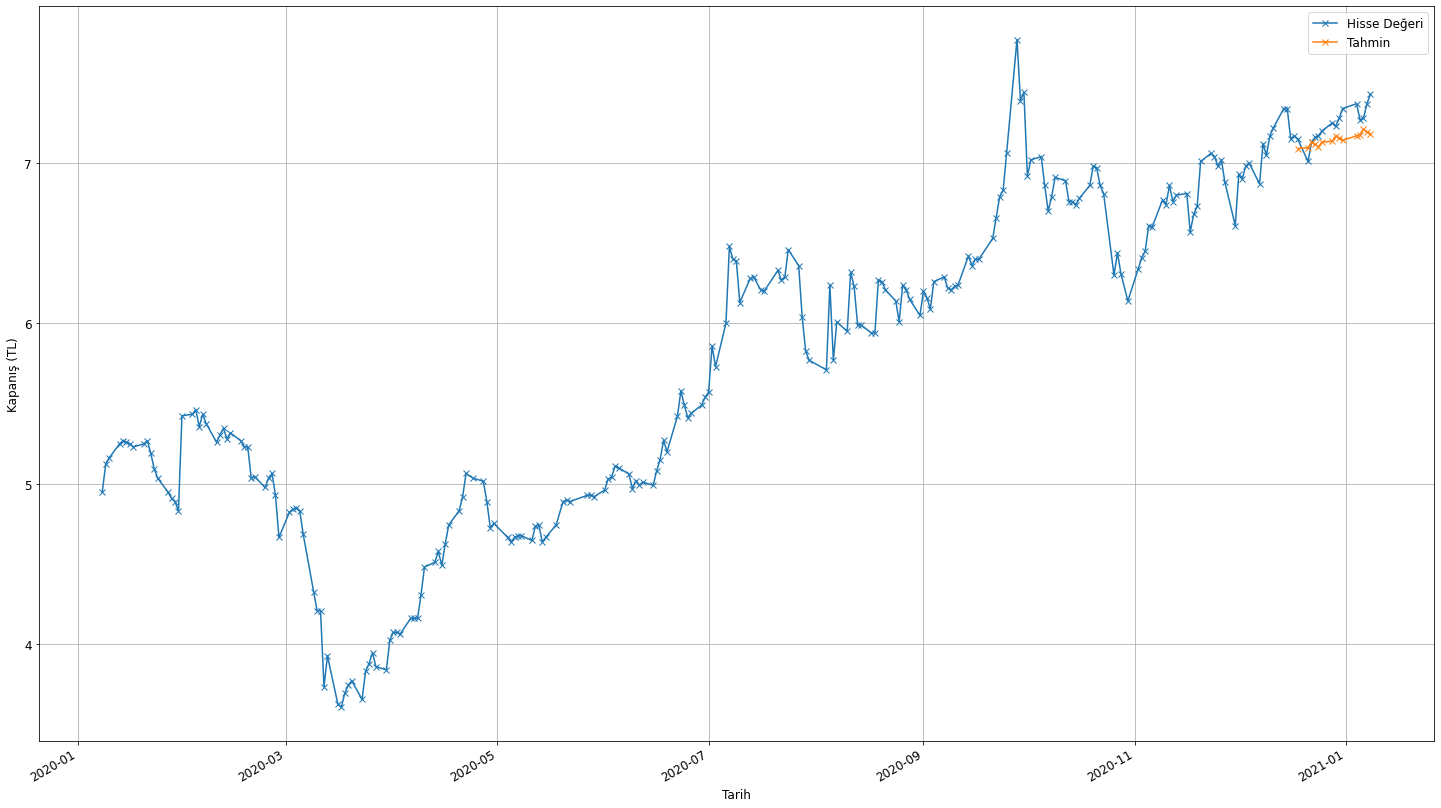

In [16]:
matplotlib.rcParams["figure.figsize"] = 25, 15
matplotlib.rcParams.update({"font.size": 12})

ax = data.plot(x="ds", y="y", style="x-", grid=True)

ax.plot(
    data["ds"][len(df_train):int(len(df_train)+(PERIOD_ESTIMATION/2))], 
    preds["yhat"][len(df_train):int(len(df_train)+(PERIOD_ESTIMATION/2))], 
    marker="x"
)
    
ax.set_xlabel("Tarih")
ax.set_ylabel("Kapanış (TL)")
ax.legend(["Hisse Değeri", "Tahmin"])

plt.savefig("out/stock_comparison.png")

In [17]:
cv = cross_validation(model, period=PERIOD_CV, horizon=PERIOD_HORIZON, parallel="processes")

cv.head(5)

INFO:fbprophet:Making 21 forecasts with cutoffs between 2020-07-10 00:00:00 and 2020-10-18 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x13b6ec100>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-13,5.887239,5.552966,6.204130,6.28,2020-07-10
1,2020-07-14,5.958996,5.622138,6.288498,6.29,2020-07-10
2,2020-07-16,5.945735,5.588610,6.284819,6.21,2020-07-10
3,2020-07-17,5.984082,5.663228,6.347051,6.20,2020-07-10
4,2020-07-21,6.099151,5.773373,6.447117,6.33,2020-07-10


In [18]:
pm = performance_metrics(cv)

pm.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,7 days,0.129489,0.359846,0.276728,0.043032,0.034756,0.741694
1,8 days,0.134109,0.366209,0.287297,0.044979,0.036251,0.718605
2,9 days,0.146946,0.383335,0.304832,0.047784,0.037215,0.703101
3,10 days,0.188877,0.434600,0.342869,0.053591,0.038849,0.666944
4,11 days,0.178382,0.422353,0.337501,0.052659,0.039491,0.655039


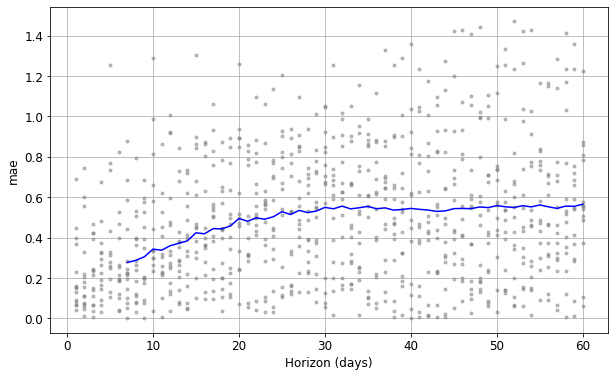

In [19]:
kpi = plot_cross_validation_metric(cv, metric="mae")